# CS 109A/STAT 121A/AC 209A/CSCI E-109A: Homework 4
# Regularization, High Dimensionality, PCA


**Harvard University**<br/>
**Fall 2017**<br/>
**Instructors**: Pavlos Protopapas, Kevin Rader, Rahul Dave, Margo Levine

---

### INSTRUCTIONS

- To submit your assignment follow the instructions given in canvas.
- Restart the kernel and run the whole notebook again before you submit. 
- Do not include your name(s) in the notebook even if you are submitting as a group. 
- If you submit individually and you have worked with someone, please include the name of your [one] partner below. 

---

Your partner's name (if you submit separately):

Enrollment Status (109A, 121A, 209A, or E109A):

Import libraries:

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
import statsmodels.api as sm
from statsmodels.api import OLS
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
%matplotlib inline

# Continuing Bike Sharing Usage Data

In this homework, we will focus on multiple linear regression, regularization, dealing with high dimensionality, and PCA. We will continue to build regression models for the Capital Bikeshare program in Washington D.C.  See Homework 3 for more information about the data.

*Note: please make sure you use all the processed data from HW 3 Part (a)...you make want to save the data set on your computer and reread the csv/json file here.


In [2]:
train_df = pd.read_csv('./data/train_processed.csv')
test_df = pd.read_csv('./data/test_processed.csv')
train_df = train_df.drop('Unnamed: 0', 1)
test_df = test_df.drop('Unnamed: 0', 1)
train_df.head()
test_df.head()

,holiday,workingday,temp,atemp,humidity,windspeed,count,season_1.0,season_2.0,season_3.0,...,day_of_week_4.0,day_of_week_5.0,day_of_week_6.0,weather_1.0,weather_2.0,weather_3.0,temp_norm,atemp_norm,humidity_norm,windspeed_norm
0,0.0,1.0,2.0,6.0,56.2083,0.194037,3830.0,1,0,0,...,1,0,0,1,0,0,-1.341801,-1.363792,-0.500703,0.040945
1,0.0,1.0,1.0,3.0,65.2917,0.350133,2114.0,1,0,0,...,1,0,0,0,1,0,-1.431146,-1.665877,0.132958,2.036025
2,0.0,1.0,36.0,37.0,56.8333,0.149883,915.0,0,1,0,...,1,0,0,0,1,0,1.695943,1.757749,-0.457103,-0.523392
3,0.0,1.0,8.0,12.0,49.0833,0.268033,4322.0,1,0,0,...,0,0,0,1,0,0,-0.805728,-0.759623,-0.997746,0.986696
4,0.0,0.0,28.0,29.0,69.7083,0.215171,6591.0,0,1,0,...,0,0,0,1,0,0,0.981180,0.952190,0.441062,0.311061


## Part (f): Regularization/Penalization Methods

As an alternative to selecting a subset of predictors and fitting a regression model on the subset, one can fit a linear regression model on all predictors, but shrink or regularize the coefficient estimates to make sure that the model does not "overfit" the training set. 

Use the following regularization techniques to fit linear models to the training set:
- Ridge regression
- Lasso regression
    
You may choose the shrikage parameter $\lambda$ from the set $\{10^{-5}, 10^{-4},...,10^{4},10^{5}\}$ using cross-validation. In each case, 

- How do the estimated coefficients compare to or differ from the coefficients estimated by a plain linear regression (without shrikage penalty) in Part (b) fropm HW 3? Is there a difference between coefficients estimated by the two shrinkage methods? If so, give an explantion for the difference.
- List the predictors that are assigned a coefficient value close to 0 (say < 1e-10) by the two methods. How closely do these predictors match the redundant predictors (if any) identified in Part (c) from HW 3?
- Is there a difference in the way Ridge and Lasso regression assign coefficients to the predictors `temp` and `atemp`? If so, explain the reason for the difference.

We next analyze the performance of the two shrinkage methods for different training sample sizes:
- Generate random samples of sizes 100, 150, ..., 400 from the training set. You may use the following code to draw a random sample of a specified size from the training set:

C:\Users\dellg7\AppData\Local\Programs\Python\Python37-32\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5172806.603232086, tolerance: 123600.21098247737
  positive)
C:\Users\dellg7\AppData\Local\Programs\Python\Python37-32\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5172868.757007778, tolerance: 123600.21098247737
  positive)
C:\Users\dellg7\AppData\Local\Programs\Python\Python37-32\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5173460.159200132, tolerance: 123600.21098247737
  positive)


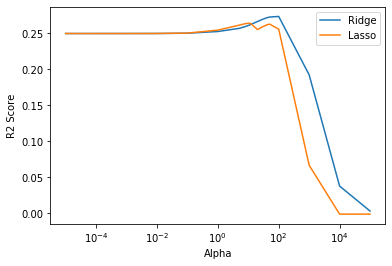

Best Lasso: 10
Best Ridge: 100


Ridge(alpha=100, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)

In [3]:
# Use Ridge and Lasso regression to create models on the training set

# Remove the numeric columns that have been normalized separately, as well as the redundant categorical columns
remove_cols = ['temp', 'atemp', 'humidity', 'windspeed', 'count', 'season_3.0', 'month_12.0', 'day_of_week_6.0', 'weather_3.0']

Xtrain = train_df[train_df.columns.difference(remove_cols)]
Xtest  = test_df[test_df.columns.difference(remove_cols)]
predictors = list(Xtrain)

# Create response 
ytrain = train_df['count']
ytest  = test_df['count']

# Added additional alpha values around 10 in order to get more precise data around this location
alphas = [.00001, .0001, .001, .01, .1, 1, 5, 8, 10, 12, 20, 30, 35, 40, 45, 50, 100, 1000, 10000, 100000]
r2s = {'ridge':[], 'lasso':[]}

for alpha in alphas:
    # Fit Lasso regression and add r2 results to r2 object
    lasso = Lasso(alpha=alpha, fit_intercept=True)
    lasso.fit(Xtrain, ytrain)
    lasso_preds = lasso.predict(Xtest)
    r2s['lasso'].append(r2_score(ytest, lasso_preds))
    
    # Fit Ridge regression add r2 results to r2 object
    ridge = Ridge(alpha=alpha, fit_intercept=True)
    ridge.fit(Xtrain, ytrain)
    ridge_preds = ridge.predict(Xtest)
    r2s['ridge'].append(r2_score(ytest, ridge_preds))
    
# Use a semilogx plot to display alpha values on a normalized scale
plt.semilogx(alphas, r2s['ridge'], label='Ridge')
plt.semilogx(alphas, r2s['lasso'], label='Lasso')
plt.ylabel("R2 Score")
plt.xlabel("Alpha")
plt.legend()
plt.show()

# Get the best r2 score found for both ridge and lasso
winningRidge = np.argmax(r2s['ridge'])
winningLasso = np.argmax(r2s['lasso'])
print("Best Lasso: "+str(alphas[winningLasso]))
print("Best Ridge: "+str(alphas[winningRidge]))

# Plot all r2 scores by their alpha value
lasso = Lasso(alpha=alphas[winningLasso], fit_intercept=True)
lasso.fit(Xtrain, ytrain)

ridge = Ridge(alpha=alphas[winningRidge], fit_intercept=True)
ridge.fit(Xtrain, ytrain)

    

In [4]:
from sklearn.linear_model import LinearRegression

linreg = LinearRegression()
linreg.fit(Xtrain, ytrain)

predictors = np.array(predictors)
coefficients = np.transpose([predictors, ridge.coef_, lasso.coef_, linreg.coef_])
coefficients_df = pd.DataFrame(coefficients, columns=['predictors', 'Ridge', 'Lasso', 'Normal'])
coefficients_df.head(len(coefficients_df))


,predictors,Ridge,Lasso,Normal
0,atemp_norm,471.6568679646039,452.3203677444377,312.43407188889427
1,day_of_week_0.0,-84.42496035271257,-306.2418651503789,-465.1450099570916
2,day_of_week_1.0,-89.06248939039176,-201.4878538767449,-256.65005066624417
3,day_of_week_2.0,-31.189729499901816,-144.64983857205658,-328.1845068956918
4,day_of_week_3.0,39.9611276784479,0.0,37.61277259519499
5,day_of_week_4.0,25.985191169271907,-0.0,-71.64254439856498
6,day_of_week_5.0,57.024461034148295,9.511149169147023,-21.83167487924194
7,holiday,-43.34246184082061,-179.77933843895488,-616.6027102985657
8,humidity_norm,-354.4763637051972,-567.6253916153483,-548.4929490582183
9,month_1.0,-157.83011306540448,-65.66318839582598,118.83581871663446


In [7]:
#--------  sample
# A function to select a random sample of size k from the training set
# Input: 
#      x (n x d array of predictors in training data)
#      y (n x 1 array of response variable vals in training data)
#      k (size of sample) 
# Return: 
#      chosen sample of predictors and responses

def sample(x, y, k):
    n = x.shape[0] # No. of training points
    
    # Choose random indices of size 'k'
    subset_ind = np.random.choice(np.arange(n), k)
    
    # Get predictors and reponses with the indices
    x_subset = x[subset_ind, :]
    y_subset = y[subset_ind]
    
    return (x_subset, y_subset)

- Fit linear, Ridge and Lasso regression models to each of the generated sample. In each case, compute the $R^2$ score for the model on the training sample on which it was fitted, and on the test set.
- Repeat the above experiment for 10 random trials/splits, and compute the average train and test $R^2$ across the trials for each training sample size. Also, compute the standard deviation (SD) in each case.
- Make a plot of the mean training $R^2$ scores for the linear, Ridge and Lasso regression methods as a function of the training sample size. Also, show a confidence interval for the mean scores extending from **mean - SD** to **mean + SD**. Make a similar plot for the test $R^2$ scores.

How do the training and test $R^2$ scores compare for the three methods? Give an explanation for your observations. How do the confidence intervals for the estimated $R^2$ change with training sample size? Based on the plots, which of the three methods would you recommend when one needs to fit a regression model using a small training sample?

*Hint:* You may use `sklearn`'s `RidgeCV` and `LassoCV` classes to implement Ridge and Lasso regression. These classes automatically perform cross-validation to tune the parameter $\lambda$ from a given range of values. You may use the `plt.errorbar` function to plot confidence bars for the average $R^2$ scores.

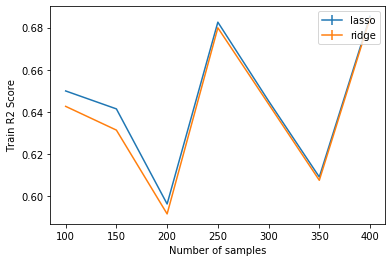

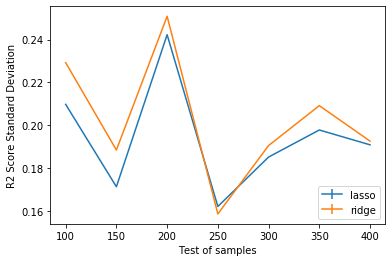

In [8]:
# your code here
sample_sizes = [100, 150, 200, 250, 300, 350, 400]
r2s = {'ridge':{}, 'lasso':{}}

for sample_size in sample_sizes:
    X_sample, y_sample = get_samples(Xtrain.values, ytrain.values, sample_size)

    r2s['ridge'][sample_size] = {'test': {'samples': [], 'std':None, 'mean':None}, 'train': {'samples': [], 'std':None, 'mean':None}}
    r2s['lasso'][sample_size] = {'test': {'samples': [], 'std':None, 'mean':None}, 'train': {'samples': [], 'std':None, 'mean':None}}
    
    for i in range(10):
        ridge = Ridge()
        ridge.fit(X_sample, y_sample)
        ridge_train_predictions = ridge.predict(X_sample)
        r2s['ridge'][sample_size]['train']['samples'].append(r2_score(y_sample, ridge_train_predictions))
        
        ridge_test_predictions = ridge.predict(Xtest)
        r2s['ridge'][sample_size]['test']['samples'].append(r2_score(ytest, ridge_test_predictions))
        
        lasso = Lasso()
        lasso.fit(X_sample, y_sample)
        lasso_train_predictions = lasso.predict(X_sample)
        r2s['lasso'][sample_size]['train']['samples'].append(r2_score(y_sample, lasso_train_predictions))
        
        lasso_test_predictions = lasso.predict(Xtest)
        r2s['lasso'][sample_size]['test']['samples'].append(r2_score(ytest, lasso_test_predictions))
        
        
    r2s['ridge'][sample_size]['train']['mean'] = np.mean(r2s['ridge'][sample_size]['train']['samples'])
    r2s['ridge'][sample_size]['train']['std'] = np.std(r2s['ridge'][sample_size]['train']['samples'])
    
    r2s['lasso'][sample_size]['train']['mean'] = np.mean(r2s['lasso'][sample_size]['train']['samples'])
    r2s['lasso'][sample_size]['train']['std'] = np.std(r2s['lasso'][sample_size]['train']['samples'])
    
    r2s['ridge'][sample_size]['test']['mean'] = np.mean(r2s['ridge'][sample_size]['test']['samples'])
    r2s['ridge'][sample_size]['test']['std'] = np.std(r2s['ridge'][sample_size]['test']['samples'])
    
    r2s['lasso'][sample_size]['test']['mean'] = np.mean(r2s['lasso'][sample_size]['test']['samples'])
    r2s['lasso'][sample_size]['test']['std'] = np.std(r2s['lasso'][sample_size]['test']['samples'])

# Plot means and standard deviations of R2 scores for sample sizes across ridge and lasso
plt.figure()
plt.xlabel("Number of samples")
plt.ylabel("Train R2 Score")
plt.errorbar(sample_sizes, [r2s['lasso'][s]['train']['mean'] for s in sample_sizes], yerr=[r2s['lasso'][s]['train']['std'] for s in sample_sizes], label='lasso')
plt.errorbar(sample_sizes, [r2s['ridge'][s]['train']['mean'] for s in sample_sizes], yerr=[r2s['ridge'][s]['train']['std'] for s in sample_sizes], label='ridge')
plt.legend(loc='upper right')
plt.show()

plt.xlabel("Test of samples")
plt.ylabel("R2 Score Standard Deviation")

plt.errorbar(sample_sizes, [r2s['lasso'][s]['test']['mean'] for s in sample_sizes], yerr=[r2s['lasso'][s]['test']['std'] for s in sample_sizes], label='lasso')
plt.errorbar(sample_sizes, [r2s['ridge'][s]['test']['mean'] for s in sample_sizes], yerr=[r2s['ridge'][s]['test']['std'] for s in sample_sizes], label='ridge')
plt.legend(loc='lower right')
plt.show()


your answers here

## Part (g): Polynomial & Interaction Terms

Moving beyond linear models, we will now try to improve the performance of the regression model in Part (b) from HW 3 by including higher-order polynomial and interaction terms. 

- For each continuous predictor $X_j$, include additional polynomial terms $X^2_j$, $X^3_j$, and $X^4_j$, and fit a multiple regression model to the expanded training set. How does the $R^2$ of this model on the test set compare with that of the linear model fitted in Part (b) from HW 3? Using a t-test, find out which of estimated coefficients for the polynomial terms are statistically significant at a significance level of 5%. 

- Fit a multiple linear regression model with additional interaction terms $\mathbb{I}_{month = 12} \times temp$ and $\mathbb{I}_{workingday = 1} \times \mathbb{I}_{weathersit = 1}$ and report the test $R^2$ for the fitted model. How does this compare with the $R^2$ obtained using linear model in Part (b) from HW 3? Are the estimated coefficients for the interaction terms statistically significant at a significance level of 5%?

In [9]:
# your code here
from sklearn.linear_model import LinearRegression

def get_summary_df(X, y):
    ols = sm.OLS(y, X).fit()
    
    summary_data = ols.summary().tables[1].data
    header = summary_data.pop(0)
    header[0] = 'predictor'

    # We get the data as strings -- convert here. 
    for i in range(len(summary_data)):
        summary_data[i][1] = float(summary_data[i][1])
        summary_data[i][2] = float(summary_data[i][2])
        summary_data[i][3] = float(summary_data[i][3])
        summary_data[i][4] = float(summary_data[i][4])
        summary_data[i][5] = float(summary_data[i][5])
        summary_data[i][6] = float(summary_data[i][6])
        
    summary_df = pd.DataFrame(summary_data, columns=header)
    return summary_df

# Predictors
numeric_cols = ['temp_norm', 'atemp_norm', 'humidity_norm', 'windspeed_norm']
Xtrain_poly = Xtrain.copy()
Xtest_poly = Xtest.copy()

# Add exponent columns for all numeric columns of the form:
# 'colname_exponent'
for numeric_col in numeric_cols:
    Xtrain_poly[numeric_col+'_2'] = Xtrain[numeric_col]**2
    Xtrain_poly[numeric_col+'_3'] = Xtrain[numeric_col]**3
    Xtrain_poly[numeric_col+'_4'] = Xtrain[numeric_col]**4
    
    Xtest_poly[numeric_col+'_2'] = Xtest[numeric_col]**2
    Xtest_poly[numeric_col+'_3'] = Xtest[numeric_col]**3
    Xtest_poly[numeric_col+'_4'] = Xtest[numeric_col]**4
Xtrain_poly.head()

# Get R2 values on test and train sets
linreg_poly = LinearRegression().fit(Xtrain_poly, ytrain)
trainPreds_poly = linreg_poly.predict(Xtrain_poly)
print("Train R2:")
print(r2_score(ytrain, trainPreds_poly))

testPreds_poly = linreg_poly.predict(Xtest_poly)
print("Test R2:")
print(r2_score(ytest, testPreds_poly))

Xtest_intercept = sm.add_constant(Xtest_poly)
summary_df = get_summary_df(Xtest_intercept, ytest)
summary_df.sort_values('P>|t|', inplace=True)
summary_df.head(30)


Train R2:
0.6696562402214017
Test R2:
0.2772384350861553


C:\Users\dellg7\AppData\Local\Programs\Python\Python37-32\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


,predictor,coef,std err,t,P>|t|,[0.025,0.975]
0,const,3651.0945,1061.216,3.440,0.001,1564.133,5738.056
29,temp_norm_2,-2759.4370,1002.647,-2.752,0.006,-4731.218,-787.656
25,weather_1.0,1984.3455,736.827,2.693,0.007,535.319,3433.372
34,atemp_norm_4,-376.7993,147.915,-2.547,0.011,-667.686,-85.913
26,weather_2.0,1774.8474,694.078,2.557,0.011,409.890,3139.805
32,atemp_norm_2,2198.9751,903.790,2.433,0.015,421.604,3976.346
7,day_of_week_5.0,521.6191,230.018,2.268,0.024,69.271,973.967
6,day_of_week_4.0,475.1143,223.309,2.128,0.034,35.960,914.269
9,humidity_norm,-454.5818,215.594,-2.109,0.036,-878.564,-30.600
15,month_4.0,-1376.1298,715.532,-1.923,0.055,-2783.277,31.017


In [10]:
Xtrain_interaction = Xtrain.copy()
Xtest_interaction = Xtest.copy()

# Numeric strings for each of the month and weather columns
months = ['1.0', '2.0', '3.0', '4.0', '5.0', '6.0', '7.0', '8.0', '9.0', '10.0', '11.0']
weathers = ['1.0', '2.0']

# Create new columns for temperature and each month
for month in months:
    Xtrain_interaction['temp_month_'+month] = Xtrain['month_'+month]* Xtrain['temp_norm']
    Xtest_interaction['temp_month_'+month] = Xtest['month_'+month]* Xtest['temp_norm']

# Create new columsn for weather and working day
for weather in weathers:
    Xtrain_interaction['working_weather_'+weather] = Xtrain['weather_'+weather] * Xtrain['workingday']
    Xtest_interaction['working_weather_'+weather] = Xtest['weather_'+weather] * Xtest['workingday']
    
Xtrain_interaction.head()

# Get test and train R2s
linreg = LinearRegression().fit(Xtrain_interaction, ytrain)
trainPreds = linreg.predict(Xtrain_interaction)
print("Train R2:")
print(r2_score(ytrain, trainPreds))

testPreds = linreg.predict(Xtest_interaction)
print("Test R2:")
print(r2_score(ytest, testPreds))

Xtest_intercept = sm.add_constant(Xtest_interaction)
summary_df = get_summary_df(Xtest_intercept, ytest)
summary_df.sort_values('P>|t|', inplace=True)
summary_df.head(30)

Train R2:
0.6691588687664332
Test R2:
0.2609472299172805


C:\Users\dellg7\AppData\Local\Programs\Python\Python37-32\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


,predictor,coef,std err,t,P>|t|,[0.025,0.975]
0,const,6783.4530,1715.005,3.955,0.000,3410.735,10200.000
39,temp_month_11.0,-4200.0521,1183.507,-3.549,0.000,-6527.529,-1872.575
35,temp_month_7.0,-5256.5515,1361.750,-3.860,0.000,-7934.562,-2578.541
34,temp_month_6.0,-6280.8525,1163.323,-5.399,0.000,-8568.636,-3993.069
24,temp_norm,5688.0955,1408.594,4.038,0.000,2917.963,8458.228
12,month_11.0,-4310.6131,1158.983,-3.719,0.000,-6589.862,-2031.364
15,month_4.0,-3661.5456,1114.181,-3.286,0.001,-5852.687,-1470.404
11,month_10.0,-2651.7798,915.024,-2.898,0.004,-4451.260,-852.299
37,temp_month_9.0,-3201.8996,1121.956,-2.854,0.005,-5408.331,-995.468
33,temp_month_5.0,-3208.4561,1166.250,-2.751,0.006,-5501.995,-914.917


In [ ]:
your answers here

## Part (h): PCA to deal with high dimensionality

We would like to fit a model to include all main effects, polynomial terms up to the $4^{th}$ order, and all interactions between all possible predictors and polynomial terms (not including the interactions between $X^1_j$, $X^2_j$, $X^3_j$, and $X^4_j$ as they would just create higher order polynomial terms).  

- Create an expanded training set including all the desired terms mentioned above.  What are the dimensions of this 'design matrix' of all the predictor variables?   What are the issues with attempting to fit a regression model using all of these predictors?

- Instead of using the usual approaches for model selection, let's instead use principal components analysis (PCA) to fit the model.  First, create the principal component vectors in python (consider: should you normalize first?).  Then fit 5 different regression models: (1) using just the first PCA vector, (2) using the first two PCA vectors, (3) using the first three PCA vectors, etc...  Briefly summarize how these models compare in the training set.

- Use the test set to decide which of the 5 models above is best to predict out of sample.  How does this model compare to the previous models you've fit?  What are the interpretations of this model's coefficients?

In [11]:
#your code here
all_predictors = list(Xtrain_poly)
non_poly_predictors = set(list(Xtrain)) - set(numeric_cols)

Xtrain_big = Xtrain_poly.copy()

Xtest_big = Xtest_poly.copy()
for predictor1 in all_predictors:
    for predictor2 in non_poly_predictors:
        Xtrain_big[predictor1+'X'+predictor2] = Xtrain_poly[predictor1]* Xtrain_poly[predictor2]
        Xtest_big[predictor1+'X'+predictor2] = Xtest_poly[predictor1]* Xtest_poly[predictor2]


numeric_strings = ['humidity', 'temp', 'windspeed']
# Get a list of all the columns with either temp, humidity, or windspeed

numeric_cols = [name for name in list(Xtrain_big) if any(num in name for num in numeric_strings)]

#Normalize the data
for numeric_col in numeric_cols:
    Xtest_big[numeric_col] = Xtest_big[numeric_col].transform(lambda x, m = Xtrain_big[numeric_col].mean(), 
                                                                          s = Xtrain_big[numeric_col].std()
                                                                          : (x - m)/s )
# Rescale train data using mean and std computed from train
Xtrain_big[numeric_cols] = Xtrain_big[numeric_cols].transform(lambda x: (x - x.mean()) / x.std())


Xtrain_big.describe()


,atemp_norm,day_of_week_0.0,day_of_week_1.0,day_of_week_2.0,day_of_week_3.0,day_of_week_4.0,day_of_week_5.0,holiday,humidity_norm,month_1.0,...,windspeed_norm_4Xmonth_4.0,windspeed_norm_4Xseason_4.0,windspeed_norm_4Xseason_1.0,windspeed_norm_4Xholiday,windspeed_norm_4Xmonth_9.0,windspeed_norm_4Xworkingday,windspeed_norm_4Xmonth_6.0,windspeed_norm_4Xmonth_7.0,windspeed_norm_4Xseason_2.0,windspeed_norm_4Xday_of_week_0.0
count,3.310000e+02,331.000000,331.000000,331.000000,331.000000,331.000000,331.000000,331.000000,3.310000e+02,331.000000,...,3.310000e+02,3.310000e+02,3.310000e+02,3.310000e+02,3.310000e+02,3.310000e+02,3.310000e+02,3.310000e+02,3.310000e+02,3.310000e+02
mean,-5.366637e-17,0.160121,0.175227,0.135952,0.123867,0.123867,0.145015,0.033233,3.219982e-17,0.078550,...,-3.219982e-17,2.683318e-17,-5.366637e-18,4.024978e-18,-5.366637e-18,-2.146655e-17,-3.488314e-17,2.951650e-17,-2.146655e-17,1.609991e-17
std,1.000000e+00,0.367273,0.380736,0.343256,0.329929,0.329929,0.352649,0.179515,1.000000e+00,0.269442,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-2.572131e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-2.648736e+00,0.000000,...,-1.151002e-01,-2.492307e-01,-1.828045e-01,-9.267390e-02,-1.297101e-01,-2.759446e-01,-1.060354e-01,-1.429757e-01,-1.717584e-01,-1.285487e-01
25%,-8.603176e-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-7.452412e-01,0.000000,...,-1.151002e-01,-2.492307e-01,-1.828045e-01,-9.267390e-02,-1.297101e-01,-2.759446e-01,-1.060354e-01,-1.429757e-01,-1.717584e-01,-1.285487e-01
50%,1.466312e-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-6.562743e-03,0.000000,...,-1.151002e-01,-2.492307e-01,-1.828045e-01,-9.267390e-02,-1.297101e-01,-2.741981e-01,-1.060354e-01,-1.429757e-01,-1.717584e-01,-1.285487e-01
75%,7.508005e-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.055719e-01,0.000000,...,-1.151002e-01,-2.492306e-01,-1.828045e-01,-9.267390e-02,-1.297101e-01,-1.735898e-01,-1.060354e-01,-1.429757e-01,-1.717577e-01,-1.285487e-01
max,1.959139e+00,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.362380e+00,1.000000,...,1.575810e+01,9.483028e+00,9.171401e+00,1.615199e+01,1.653635e+01,9.827090e+00,1.678698e+01,1.147399e+01,1.145323e+01,1.626381e+01


In [12]:
from sklearn.decomposition import PCA
from sklearn import preprocessing

for n_comp in range(1,6):
    pca = PCA(n_components = n_comp)
#   Apply Scaling to Xtrain_big and Xtest_big
    std_scale = preprocessing.StandardScaler().fit(Xtrain_big)
    X_train_std = std_scale.transform(Xtrain_big)
    X_test_std = std_scale.transform(Xtest_big)
#   Perform PCA
    pca.fit(X_train_std)
#   Apply the dimensionality reduction on X_train_std and X_test_std
    Xtrain_big_pca = pca.transform(X_train_std)
    Xtest_big_pca  = pca.transform(X_test_std)
#   Create LR model
    lr = LinearRegression()
    #  Fit the LR model with reduced dimensional train data
    lr.fit(Xtrain_big_pca, ytrain)
    # Predict on reduced dimensional test datatest
    ytest_pred = lr.predict(Xtest_big_pca)
    # Get R2 test score
    r2_score_test = r2_score(ytest, ytest_pred)
    print("\nR2 LR Test Score with " + str(n_comp) + " principal components:  %5.3f" % r2_score_test)


R2 LR Test Score with 1 principal components:  0.190

R2 LR Test Score with 2 principal components:  0.196

R2 LR Test Score with 3 principal components:  0.208

R2 LR Test Score with 4 principal components:  0.222

R2 LR Test Score with 5 principal components:  0.224


your answers here

## Part (i): Beyond Squared Error

We have seen in class that the multiple linear regression method optimizes the Mean Squared Error (MSE) on the training set. Consider the following alternate evaluation metric, referred to as the Root Mean Squared Logarthmic Error (RMSLE):

$$
\sqrt{\frac{1}{n}\sum_{i=1}^n (log(y_i+1) - log(\hat{y}_i+1))^2}.
$$

The *lower* the RMSLE the *better* is the performance of a model. The RMSLE penalizes errors on smaller responses more heavily than errors on larger responses. For example, the RMSLE penalizes a prediction of $\hat{y} = 15$ for a true response of $y=10$ more heavily than a prediction of $\hat{y} = 105$ for a true response of $100$, though the difference in predicted and true responses are the same in both cases. 

This is a natural evaluation metric for bike share demand prediction, as in this application, it is more important that the prediction model is accurate on days where the demand is low (so that the few customers who arrive are served satisfactorily), compared to days on which the demand is high (when it is less damaging to lose out on some customers).

The following code computes the RMSLE for you:

In [13]:
from sklearn.linear_model import LinearRegression

#--------  rmsle
# A function for evaluating Root Mean Squared Logarithmic Error (RMSLE)
# of the linear regression model on a data set
# Input: 
#      y_test (n x 1 array of response variable vals in testing data)
#      y_pred (n x 1 array of response variable vals in testing data)
# Return: 
#      RMSLE (float) 

def rmsle(y, y_pred): 
    # Evaluate sqaured error, against target labels
    # rmsle = \sqrt(1/n \sum_i (log (y[i]+1) - log (y_pred[i]+1))^2)
    rmsle_ = np.sqrt(np.mean(np.square(np.log(y+1) - np.log(y_pred+1))))
    
    return rmsle_

Use the above code to compute the training and test RMSLE for the polynomial regression model you fit in Part (g). 

You are required to develop a strategy to fit a regression model by optimizing the RMSLE on the training set. Give a justification for your proposed approach. Does the model fitted using your approach yield lower train RMSLE than the model in Part (g)? How about the test RMSLE of the new model? 

**Note:** We do not require you to implement a new regression solver for RMSLE. Instead, we ask you to think about ways to use existing built-in functions to fit a model that performs well on RMSLE. Your regression model may use the same polynomial terms used in Part (g).

In [14]:
# your code here
weighted_linreg = LinearRegression().fit(Xtrain_poly, np.log1p(ytrain))
#
weighted_train_pred = np.expm1(weighted_linreg.predict(Xtrain_poly))
weighted_test_pred  = np.expm1(weighted_linreg.predict(Xtest_poly))
#
rmsleVals_train_weighted = rmsle(ytrain, weighted_train_pred)
rmsleVals_test_weighted = rmsle(ytest, weighted_test_pred)   
#
print("Train RMSLE - Part (g) Polynomial regression model:")
print (rmsle(ytrain, trainPreds_poly))
print("Test RMSLE - Part (g) Polynomial regression model:")
print (rmsle(ytest, testPreds_poly))
#
print("\n\nPolynomial regression model with predictors transformed into logspace.\n\
Predictions are then transformed back into original space:")
print("\nTrain RMSLE - Our approach:")
print(rmsleVals_train_weighted)
print("Test RMSLE - Our approach:")
print(rmsleVals_test_weighted)

Train RMSLE - Part (g) Polynomial regression model:
0.3106448773475638
Test RMSLE - Part (g) Polynomial regression model:
0.5242723327381416


Polynomial regression model with predictors transformed into logspace.
Predictions are then transformed back into original space:

Train RMSLE - Our approach:
0.2911699853673308
Test RMSLE - Our approach:
0.523548495829776


C:\Users\dellg7\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in log
  from ipykernel import kernelapp as app


your answers here

## Part (j): Dealing with Erroneous Labels

Due to occasional system crashes, some of the bike counts reported in the data set have been recorded manually. These counts are not very unreliable and are prone to errors. It is known that roughly 5% of the labels in the training set are erroneous (i.e. can be arbitrarily different from the true counts), while all the labels in the test set were confirmed to be accurate. Unfortunately, the identities of the erroneous records in the training set are not available. Can this information about presence of 5% errors in the training set labels (without details about the specific identities of the erroneous rows) be used to improve the performance of the model in Part (g)? Note that we are interested in improving the $R^2$ performance of the model on the test set (not the training $R^2$ score). 

As a final task, we require you to come up with a strategy to fit a regression model, taking into account the errors in the training set labels. Explain the intuition behind your approach (we do not expect a detailed mathematical justification). Use your approach to fit a regression model on the training set, and compare its test $R^2$ with the model in Part (g).

**Note:** Again, we do not require you to implement a new regression solver for handling erroneous labels. It is sufficient that you to come up with an approach that uses existing built-in functions. Your regression model may use the same polynomial terms used in Part (g).

In [15]:
# your code here
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
#  Fit the LR model
lr.fit(Xtrain, ytrain)
# Predict on train
ytrain_pred = lr.predict(Xtrain)
# Predict on test
ytest_pred = lr.predict(Xtest)
# Get R2 test score
r2_score_test = r2_score(ytest, ytest_pred)
print("\nR2 LR Test Score with full train")
print (r2_score_test)
#  Get the residuals
abs_residuals = abs(ytrain_pred - ytrain)
# Sort of residual absolute values
abs_res = abs_residuals.sort_values(axis=0, ascending= False)
# Get indexes of Xtrain that DON'T include the 5% (16) worst residuals 
inds = abs_res.index[int(len(abs_res)*0.05):len(abs_res)]

#  Fit the LR model on the train subset with worst residual indexes removed
lr.fit(Xtrain.loc[inds], ytrain.loc[inds])
# Predict on test
ytest_pred = lr.predict(Xtest)
# Get R2 test score
r2_score_test = r2_score(ytest, ytest_pred)
print("\nR2 LR Test Score with partial train after removing 5% (16) of the worst residuals")
print (r2_score_test)



R2 LR Test Score with full train
0.2493421114652754

R2 LR Test Score with partial train after removing 5% (16) of the worst residuals
0.2502030963539168


In [16]:
def outliers(X, y, n):
    # Performs a linear regression, removes n outliers and returns the
    # X and y values
    linreg = LinearRegression().fit(X, y)
    preds = linreg.predict(X)
    print(r2_score(preds, y))
    differences = np.array(np.abs(preds - y))
    for i in range(n):
        maxIdx = np.argmax(differences)
        differences = np.delete(differences, [maxIdx])
        X.drop(X.index[maxIdx], inplace=True)
        y.drop(y.index[maxIdx], inplace=True)
    return X, y, linreg


X_train_outlier = Xtrain.copy()
y_train_outlier = ytrain.copy()

# Remove 2 outliers for each pass, repeat 8 times
# 16 points is approximately 5% of the data
for i in range(8):
    X_train_outlier, y_train_outlier, linreg = outliers(X_train_outlier, y_train_outlier, 2)

# Get final R2 for test and train data
linreg = LinearRegression().fit(X_train_outlier, y_train_outlier)
train_preds = linreg.predict(X_train_outlier)
print("\nFinal R2 Score on Train Data")
print(r2_score(y_train_outlier, train_preds))

test_preds = linreg.predict(Xtest)
print("\nR2 Score on Test Data")
print(r2_score(ytest, test_preds))

0.2642751428540475
0.29332896244044004
0.32086037704005754
0.3512125865653366
0.38504248588645273
0.40632126482535313
0.4152979214900163
0.43724055072814594

Final R2 Score on Train Data
0.6447916428148446

R2 Score on Test Data
0.248176970475816


---
--_

# APCOMP209a - Homework Question



##  Question 1: Student's t MLE

Use Maximum Likelihood Estimation to generate a linear regression model on the data provided in ``beerdata.csv`` considering two statistical models for noise: a) iid Normal and b) iid Student's t-distribution with $\nu=5$ and scale factor σ=0.5.  

Compare the two models performances and comment why it is perhaps appropriate to use the Student's t-distribution instead of the Normal? 





HINTS:
1. Use the probability density function for the Student's t distribution  with location μ and scale factor σ.
2. If the MLE regressions coefficients can not be derived analytically consider numerical methods.
3. You can use sklearn or statsmodel for the Normal case 




## Question 2 (continued from HW2) 

Read sections 1 and 2 of this [paper](https://www.researchgate.net/profile/Roberto_Togneri/publication/45094554_Linear_Regression_for_Face_Recognition/links/09e4150d243bd8b987000000/Linear-Regression-for-Face-Recognition.pdf). 

Briefly, the model leverages the concept that "patterns from a single-object class lie on a linear subspace."   It also makes use of the idea of linear regression as a problem about projections.  In this case, given a vector $y$, the goal is to find the subspace induced by $\mathrm{Col} \, \mathbf X$ that produced the 'closest' projection vector $\widehat y$ to the original $y$.  

### Question 2a

As discussed in the paper, our face dataset contains cleaned images of faces belonging to different people. Assuming that patterns (faces) from one class (person) are elements of the same subspace, let's try to classify an unknown face using the method presented in the paper.  For each class $i$, we need to:

1. construct the $\mathbf H_i$ hat matrix from known faces, being careful to follow the column concatenation step described in the paper to convert an image into its vector representation;
2. calculate the predicted $\widehat y_i$, the closest vector in $\mathrm{Col} \, \mathbf X_i$ to $y$; and
3. calculate the magnitude of the difference vector between $y$ and $\widehat y_i$.

You should then be able to make a classification decision.

**Notes:**
- Use the provided code to download and re-sample the dataset.
- Follow the normalisation step in the paper to ensure the "maximum pixel value is 1".
- Your classifier should have approximately an 80% accuracy.
- Use the image plotting library of matplotlib to display one (or two) correctly classified faces and the known faces.
- Use the image plotting library of matplotlib to display one (or two) incorrectly classified faces and the known faces.
    
### Question 2b - Significant Faces
Select an example of a correctly classified face. Use statsmodels to investigate the most predictive columns (faces) that the model used in this regression:

(i) Which columns (i.e. faces) make the highest contribution to the projection?

(ii) Which columns (i.e. faces) are the least useful in making this projection?

Plot the correctly assigned face, and the two faces from the questions (i) and (ii). What do you notice about these faces?

In [2]:
from io import BytesIO
from zipfile import ZipFile
import urllib
import os

# Note that you may need to run the following command to install Python Image Library (PIL)
#pip install Pillow
from PIL import Image
import numpy as np
from sklearn.model_selection import train_test_split

import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline

In [7]:
# starter functions provided to students
def rgb2gray(rgb):
    '''
    function to convert RGB image to gray scale
    accepts 3D numpy array and returns 2D array with same dimensions
    as the first two dimensions of input
    '''
    
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])

def fetch_and_read_data(shape=(50,30)):
    
    '''
    Function to download image data, store in a local folder (note this is 18.4mb), only download the data when
    the local folder is not present, read in the images, downsample them to the specified shape (default = (50x30) (rows x cols))
    and finally split them into a four tuple return object.
    
    Returns:
        - 1) training image data (i.e. images that should form the predictor matrix in your solution)
        - 2) training image data labels (i.e. labels from 1 to 50 that identify which face (1) belongs to)
        - 3) testing image data (i.e. data that you should use to try and classify - note this forms the predictor variable in your regression)
        - 4) testing image data labels (i.e. the labels for (3) - this is to allow you to evaluate your model)
    
    ___________________
    Aside:
    If you want to change the sampling dimensions of your data, pass the shape = (x,y) argument to the method where
    y is the number of columns and x is the number of rows in the image.
    '''
    
    if not os.path.exists('./cropped_faces'):
        url = urllib.request.urlopen("http://www.anefian.com/research/GTdb_crop.zip")
        
        zipfile = ZipFile(BytesIO(url.read()))
        zipfile.extractall()
     
    data = []
    labels = []
    
    files = os.listdir('cropped_faces')
    for f in files:
        if '.jpg' in f:
            image = Image.open('cropped_faces/' + f)
            image = image.resize((shape[1], shape[0]))
            data.append(rgb2gray(np.asarray(image)))
            labels.append(int(f.split('_')[0][1:]) - 1)
            
    data = np.array(data)
    
    trainX, testX, trainY, testY = train_test_split(data, labels, test_size=0.2, stratify=labels)
    return np.array(trainX), np.array(testX), np.array(trainY), np.array(testY)

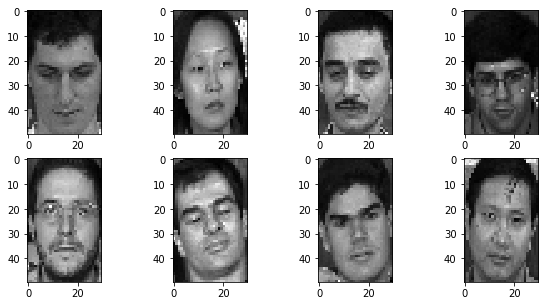

In [8]:
# starter code for the students
train_dataset, test_dataset, train_labels, test_labels = fetch_and_read_data()

# code to plot some of the images
fig, axes = plt.subplots(2,4,figsize=(10,5))
axes = axes.flatten()
[axes[i].imshow(train_dataset[i], cmap='gray') for i in range(len(axes))]
plt.show()